# Classifieur de conditions valves

## Première approche
Nous voulons prédire si les conditions valves sont optimales ou pas.

Il y a 2000 exemples (cycles) d'entrainements pour 6600 variables. Cela répresente clairement un pb de dimension.
Il y a differents moyens pour reduire la dimension.
Comme premiere approche, je propose d'echantillonner les variables d'entrée en ne gardant que 10 mesures pour FS1 et PS2 par cycle.
En outre, on va ajouter la moyenne par cycle qui peut avoir une importance.

Ensuite, je construirais un classifieur supervisé pour prédire les conditions valves.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

## Données profile
Le fichier profile contient plusieurs conditions cibles on ne recupére ici que les conditions valves.

In [2]:
#Lecture des données cibles (Valve condition)
df_v = pd.read_table("data/profile.txt",sep="\t", usecols=[1], names=['valve_condition'])
df_v.head()
df_v.tail(10)

#Fonction de conversion de condition valve en status optimal (1) ou non (0)
def is_optimal(x):
    if x==100:
        return 1
    else:
        return 0   
    
df_v["optimal"] = df_v["valve_condition"].map(is_optimal)
df_v["optimal"].value_counts()

optimal
1    1125
0    1080
Name: count, dtype: int64

## Données fs1 (volume flow)

On recupere les données en dataframe pour une meilleure analyse

In [3]:
n_vars = 600
col_names  = [f"fs_{i}" for i in range (n_vars)] #nom des colonnes
df_fs = pd.read_table("data/FS1.txt",sep="\t", names=col_names)
df_fs.head()
#len(df_fs)
#df_fs.shape

,fs_0,fs_1,fs_2,fs_3,fs_4,fs_5,fs_6,fs_7,fs_8,fs_9,...,fs_590,fs_591,fs_592,fs_593,fs_594,fs_595,fs_596,fs_597,fs_598,fs_599
0,8.990,0.770,0.641,0.006,0.000,0.000,0.001,0.003,0.001,0.001,...,7.743,7.992,7.919,7.773,7.955,7.823,7.963,7.876,7.738,8.036
1,8.919,0.815,0.709,0.009,0.004,0.000,0.001,0.000,0.000,0.001,...,7.831,8.003,7.923,7.745,7.867,7.747,7.969,7.969,7.963,7.890
2,9.179,0.683,0.528,0.008,0.003,0.001,0.003,0.003,0.004,0.006,...,7.862,7.815,7.894,7.743,7.936,7.770,7.982,7.873,7.898,7.952
3,9.034,0.728,0.595,0.009,0.001,0.004,0.003,0.003,0.003,0.001,...,7.631,7.949,7.773,8.054,7.827,8.011,7.919,7.938,7.877,7.773
4,8.729,0.705,0.446,0.014,0.007,0.003,0.001,0.003,0.001,0.000,...,7.771,7.936,7.919,7.946,7.804,7.983,7.838,7.882,7.894,7.825


## Données ps2 (pression)

On recupere les données en dataframe pour une meilleure analyse

In [4]:
#Lecture ps2 (pression)
n_vars = 6000
col_names  = [f"ps_{i}" for i in range (n_vars)] #nom des colonnes
df_ps = pd.read_table("data/PS2.txt",sep="\t", names=col_names)
df_ps.head()



,ps_0,ps_1,ps_2,ps_3,ps_4,ps_5,ps_6,ps_7,ps_8,ps_9,...,ps_5990,ps_5991,ps_5992,ps_5993,ps_5994,ps_5995,ps_5996,ps_5997,ps_5998,ps_5999
0,125.50,125.39,125.40,125.03,124.05,123.18,104.01,56.500,23.992,18.406,...,125.02,125.00,125.10,125.09,124.98,124.91,124.98,125.11,125.14,125.10
1,125.06,125.08,125.09,124.69,123.84,123.14,103.63,63.687,28.359,21.711,...,124.80,124.88,125.13,125.22,125.09,124.98,125.06,125.13,125.09,125.04
2,125.13,125.27,125.23,124.74,123.94,123.23,106.35,60.516,26.258,19.258,...,124.61,124.69,124.74,124.71,124.59,124.64,124.74,124.73,124.77,124.88
3,124.93,124.96,124.92,124.41,123.60,122.88,103.99,58.859,27.781,21.469,...,124.82,124.79,124.69,124.69,124.77,124.83,124.69,124.53,124.51,124.59
4,124.72,124.74,124.66,124.31,123.57,122.74,105.94,62.648,30.875,23.883,...,124.80,124.67,124.49,124.56,124.69,124.62,124.45,124.41,124.47,124.51


## Preparation des données d'entrainement

In [5]:
# On crée 1 liste de colonnes correspondant aux 10 echantillons pour FS1
# on choisi 10 positions à intervalle régulier sur tout le cycle
idx1 = list(range(29,600,60))
col_idx1 = [f"fs_{i}" for i in idx1]
col_idx1

['fs_29',
 'fs_89',
 'fs_149',
 'fs_209',
 'fs_269',
 'fs_329',
 'fs_389',
 'fs_449',
 'fs_509',
 'fs_569']

In [6]:
#On cree le dataset avec 11 variables (incluant la moyenne)
df_fs['fs_mean'] = df_fs.mean(axis=1)
col_idx1.append('fs_mean')
df1 = df_fs[col_idx1]
df1.head()

,fs_29,fs_89,fs_149,fs_209,fs_269,fs_329,fs_389,fs_449,fs_509,fs_569,fs_mean
0,0.003,0.000,8.041,7.909,7.819,7.775,7.933,8.089,8.038,7.730,6.709815
1,0.000,0.001,8.246,7.741,7.840,7.733,7.760,7.930,8.040,7.875,6.715315
2,0.000,0.001,7.867,7.779,7.768,7.817,7.655,7.695,7.785,7.999,6.718522
3,0.004,0.000,7.991,7.783,7.843,7.866,7.728,7.838,7.883,7.934,6.720565
4,0.001,0.003,7.854,7.970,7.835,7.879,7.841,7.950,7.803,7.786,6.690308


In [7]:
#  On crée 1 liste de colonnes correspondant aux 10 echantillons pour PS2
idx2 = list(range(299,6000,600))
col_idx2 = [f"ps_{i}" for i in idx2]
col_idx2

['ps_299',
 'ps_899',
 'ps_1499',
 'ps_2099',
 'ps_2699',
 'ps_3299',
 'ps_3899',
 'ps_4499',
 'ps_5099',
 'ps_5699']

In [8]:
df_ps['ps_mean'] = df_ps.mean(axis=1)
col_idx2.append('ps_mean')
df2 = df_ps[col_idx2]
df2.head()

,ps_299,ps_899,ps_1499,ps_2099,ps_2699,ps_3299,ps_3899,ps_4499,ps_5099,ps_5699,ps_mean
0,0.0,0.0,119.98,130.69,130.17,140.65,140.52,130.27,125.29,125.22,109.466914
1,0.0,0.0,120.18,130.33,130.28,140.44,140.43,130.13,125.06,124.88,109.354890
2,0.0,0.0,119.81,130.09,129.69,140.25,140.31,129.96,124.77,124.62,109.158845
3,0.0,0.0,119.73,129.81,129.81,140.23,140.10,129.76,124.62,124.69,109.064807
4,0.0,0.0,119.96,129.74,130.02,140.18,140.02,129.82,124.43,124.43,108.931434


In [9]:
#On concatene les données
df = df1.join(df2)
df.head()

,fs_29,fs_89,fs_149,fs_209,fs_269,fs_329,fs_389,fs_449,fs_509,fs_569,...,ps_899,ps_1499,ps_2099,ps_2699,ps_3299,ps_3899,ps_4499,ps_5099,ps_5699,ps_mean
0,0.003,0.000,8.041,7.909,7.819,7.775,7.933,8.089,8.038,7.730,...,0.0,119.98,130.69,130.17,140.65,140.52,130.27,125.29,125.22,109.466914
1,0.000,0.001,8.246,7.741,7.840,7.733,7.760,7.930,8.040,7.875,...,0.0,120.18,130.33,130.28,140.44,140.43,130.13,125.06,124.88,109.354890
2,0.000,0.001,7.867,7.779,7.768,7.817,7.655,7.695,7.785,7.999,...,0.0,119.81,130.09,129.69,140.25,140.31,129.96,124.77,124.62,109.158845
3,0.004,0.000,7.991,7.783,7.843,7.866,7.728,7.838,7.883,7.934,...,0.0,119.73,129.81,129.81,140.23,140.10,129.76,124.62,124.69,109.064807
4,0.001,0.003,7.854,7.970,7.835,7.879,7.841,7.950,7.803,7.786,...,0.0,119.96,129.74,130.02,140.18,140.02,129.82,124.43,124.43,108.931434


In [10]:
df_y = df_v["optimal"].copy()
df_y.head()

0    1
1    1
2    1
3    1
4    1
Name: optimal, dtype: int64

## Separation données entrainement et données de validation

In [13]:
#Separation données entrainement et données de validation
#Comme demandé, on prend les 2000 premiers cycles pour l'entrainement et on garde le reste pour la validation/test final
df_train = df.iloc[:2000]
df_train.shape
df_train.tail()
df_valid = df.iloc[2000:]
df_valid.tail()

,fs_29,fs_89,fs_149,fs_209,fs_269,fs_329,fs_389,fs_449,fs_509,fs_569,...,ps_899,ps_1499,ps_2099,ps_2699,ps_3299,ps_3899,ps_4499,ps_5099,ps_5699,ps_mean
2200,0.0,0.000,7.797,7.988,7.664,7.660,7.802,7.925,7.747,7.791,...,0.0,120.69,130.67,130.66,140.52,140.31,130.55,126.09,126.04,109.779581
2201,0.0,0.001,7.946,8.039,7.691,7.828,7.992,7.789,8.011,7.999,...,0.0,120.81,130.47,130.48,140.49,140.52,130.39,125.88,125.58,109.787481
2202,0.0,0.000,7.764,7.995,7.678,7.854,7.874,7.759,7.971,7.671,...,0.0,120.73,130.59,130.69,140.44,140.47,130.46,125.77,125.68,109.756174
2203,0.0,0.000,7.776,7.944,7.789,7.701,7.891,7.755,7.761,7.707,...,0.0,121.03,130.61,130.51,140.23,140.44,130.59,125.69,125.89,109.793884
2204,0.0,0.000,7.763,7.998,7.772,7.665,7.772,7.833,7.712,7.750,...,0.0,120.98,130.62,130.70,140.57,140.28,130.44,125.79,125.86,109.792177


In [14]:
dfy_train = df_y.iloc[:2000] 
dfy_valid = df_y.iloc[2000:]
dfy_train.tail()

1995    0
1996    0
1997    0
1998    0
1999    0
Name: optimal, dtype: int64

## Entrainement d'un classifieur

In [15]:
#On separe à nouveau en train/test
X_train, X_test, y_train, y_test = train_test_split(df_train, dfy_train, stratify=dfy_train, random_state=42, test_size=0.1)
X_train.shape

(1800, 22)

In [16]:
#Construction d'un modele de classifieur avec random forest
rf = RandomForestClassifier(n_estimators=100, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=0)

In [17]:
#Evaluation sur les données de test
y_pred = rf.predict(X_test)
target_values = ["class_not_optimal (0)","class_optimal (1)"]
print("Classification report:\n",classification_report(y_test, y_pred, target_names=target_values))

Classification report:
                        precision    recall  f1-score   support

class_not_optimal (0)       0.89      0.97      0.93        95
    class_optimal (1)       0.97      0.90      0.93       105

             accuracy                           0.93       200
            macro avg       0.93      0.93      0.93       200
         weighted avg       0.93      0.93      0.93       200



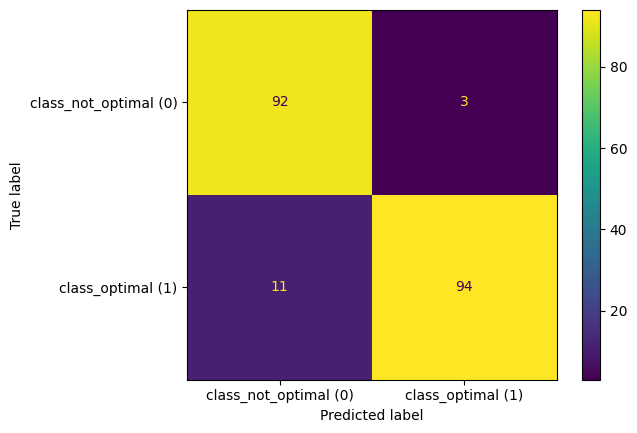

In [19]:
#Matrice de confusion
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=target_values)
plt.show()

In [20]:
# Les resultats ont l'air bons avec une accuracy de 0,93
# On re-entraine sur l'ensemble des données train

rf.fit(df_train, dfy_train)


RandomForestClassifier(random_state=0)

## Test sur les données de validations

In [21]:
#On teste cette fois sur les données de validation
y_pred = rf.predict(df_valid)
target_values = ["class_not_optimal (0)","class_optimal (1)"]
print("Classification report:\n",classification_report(dfy_valid, y_pred, target_names=target_values))

Classification report:
                        precision    recall  f1-score   support

class_not_optimal (0)       0.89      0.88      0.88       132
    class_optimal (1)       0.78      0.79      0.79        73

             accuracy                           0.85       205
            macro avg       0.83      0.84      0.84       205
         weighted avg       0.85      0.85      0.85       205



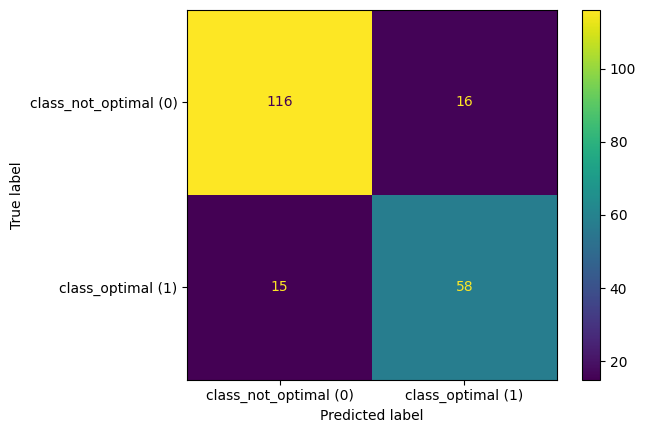

In [22]:
ConfusionMatrixDisplay.from_predictions(dfy_valid, y_pred, display_labels=target_values)
plt.show()

## Conclusion

Les résultats de performance du classifieur (avec la premiere approche) sur les données de validation sont un peu moins bons que sur les données de test mais ils restent néanmoins satisfaisants avec une accuracy globale de 0.85.

Avec plus de temps, on pourrait investiguer:
* d'autres techniques d'extraction de variables (autres echantillonages, etc)
* d'autres algo de classification (Random Forest est simple et rapide mais d'autres algo pourraient être plus performants).

